VOR beacon transmitter signal propagation model
===============================================

* Generation of artificial VOR signal.
* Calculate Doppler shift of meteor reflection
* Create a Monte-Carlo simulation of multiple meteors above the VOR transmitter to get an assessment of the feasibility of reflected signal detection. 


## Frequency signal model

Symplified C-VOR formulas from source: http://www.f4gkr.org/in-depth-study-of-the-vor-signals/

In [ ]:
import sympy
import numpy as np
import local_utils

%pylab inline

In [4]:
t = sympy.Symbol('t')  # time
Fc = sympy.Symbol('F_c')  # carrier frequency (108 - 118MHz)
Fref = sympy.Symbol('F_ref') # Reference subcarrier offset 9960Hz
Fb = sympy.Symbol('F_b') # Variable signal modulation 30Hz
alpha = sympy.Symbol('alpha') # modulation index Typ: 0.3
theta = sympy.Symbol('Theta') # Bearing

sref = sympy.cos(2*pi*Fref*t+16*sympy.sin(2*pi*Fb*t))
svar = sympy.cos(2*pi*Fb*t+theta)

s = sympy.exp(sympy.I*2*pi*Fc*t)* (1 + alpha*sref + svar)



In [5]:
s

(alpha*cos(6.28318530717959*F_ref*t + 16*sin(6.28318530717959*F_b*t)) + cos(6.28318530717959*F_b*t + Theta) + 1)*exp(6.28318530717959*I*F_c*t)

In [6]:
sref

cos(6.28318530717959*F_ref*t + 16*sin(6.28318530717959*F_b*t))

In [7]:
svar

cos(6.28318530717959*F_b*t + Theta)

In [8]:
Carrier_frequency = 15e3
Fs = 60e3

x_vec = numpy.arange(0, 0.5, 1/Fs)
f = sympy.lambdify([t, theta], s.subs([(Fc, Carrier_frequency), (Fref, 9960), (Fb, 30), (alpha, 0.3)], simultaneous=True), 'numpy')

In [9]:
y_vec = numpy.array([np.real(f(xx, 100)) for xx in x_vec])

/usr/lib/python2.7/dist-packages/numpy/core/numeric.py:460: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


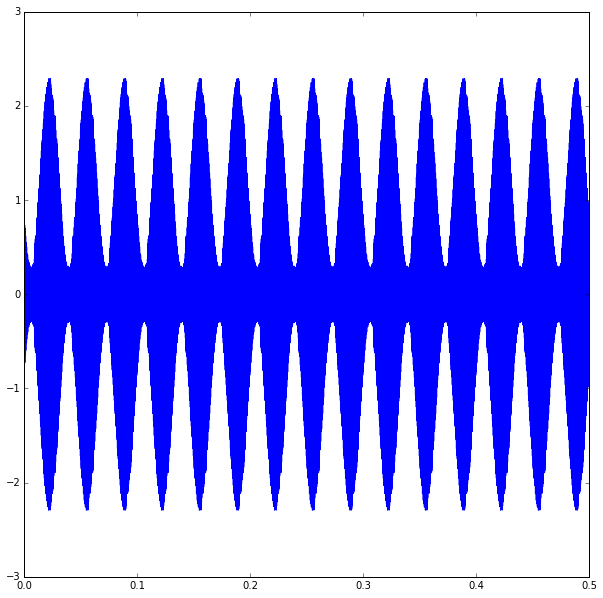

In [44]:
fig, ax = subplots(figsize=(10, 10))
ax.plot(x_vec, y_vec);

In [11]:
y_vec

array([  2.16231887e+00,  -3.21910678e-16,  -1.69221177e+00, ...,
         4.90656222e-13,  -1.68584863e+00,   3.66706847e-12])

In [12]:
y_vec = f(x_vec, 90)

In [13]:
import scipy
from __future__ import division

def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

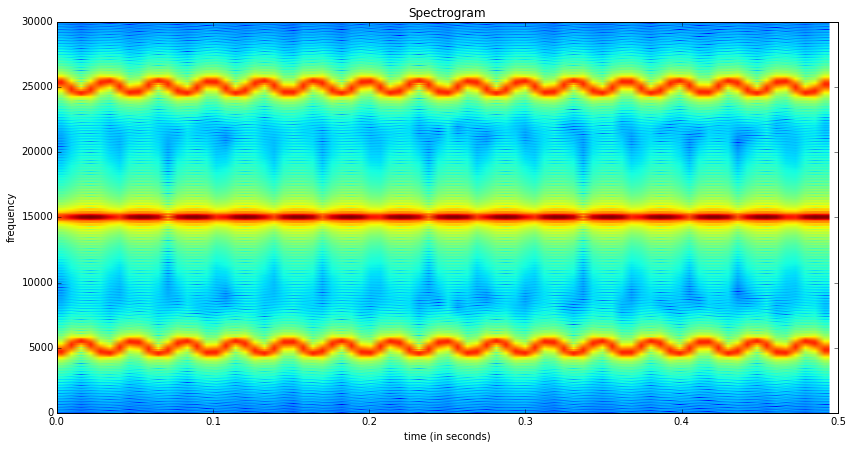

In [14]:
setup_graph(title='Spectrogram', x_label='time (in seconds)', y_label='frequency', fig_size=(14,7))
_ = specgram(y_vec, NFFT=500, pad_to=32568, Fs=Fs, sides='onesided')

## Signal intensity model

In [1]:
import sympy
import numpy as np
import local_utils

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
Pt = sympy.Symbol('P_t')  #  transmitter power in Watts
PdB = sympy.Symbol('P_t')  #  power in dBm
Gt = sympy.Symbol('G_t')  #  gain of the transmitting antenna
Ar = sympy.Symbol('A_r') # effective aperture (area) of the receiving antenna (most of the time noted as Gr)
RCS = sympy.Symbol('delta') # radar cross section, or scattering coefficient, of the target
F = sympy.Symbol('F') # pattern propagation factor
Rt = sympy.Symbol('R_t') # distance from the transmitter to the target
Rr = sympy.Symbol('R_r') # distance from the target to the receiver.

PW = 10 * sympy.log(PdB/0.001, 10)
Pr = (Pt*Gt*Ar*RCS*F**4)/((4*pi)**2  * Rt**2 * Rr**2)
PrdBm = PW.subs([(PdB,Pr)], simultaneous=True)

In [3]:
sympy.N(PrdBm.subs([(Pt, 200), (Gt, 3), (Ar, 5), (RCS, 100), (F, 1), (Rt, 10e3), (Rr, 10e3)], simultaneous=True))

-97.2129847332453

System constants

In [4]:
#Artificial meteors coordinates:

ZHR = 100 

met_start_altitude = np.random.normal(100e3,20e3,ZHR)
met_stop_altitude = np.random.normal(60e3,20e3,ZHR)

met_start_lat = np.random.normal(50,2,ZHR)  
met_start_lon = np.random.normal(14,2,ZHR)

met_stop_lat = np.random.normal(50,2,ZHR) 
met_stop_lon = np.random.normal(14,2,ZHR)

met_velocity = np.random.normal(50000,20000,ZHR)



Find near transmitter to defined reception station.

In [5]:
signal_radius = 200 # Maximal ground distance to transmitter in km
rec_station_lat = 50  # define reception station coordinates (in WGS84)
rec_station_lon = 14
rec_station_altitude = 200

near_transmitters = local_utils.find_near_transmitters(rec_station_lat, rec_station_lon, signal_radius)

URLError: <urlopen error [Errno -3] Temporary failure in name resolution>

Convert imperial feet elevation in to metric convention.
Set specific transmission power instead of LOW, MEDIUM and High keywords.

In [21]:
for transmitter in near_transmitters.index:
    near_transmitters.loc[transmitter, 'elevation_m'] = local_utils.f2m(near_transmitters.ix[transmitter].elevation_ft)
    if near_transmitters.ix[transmitter].power == 'LOW':
        near_transmitters.loc[transmitter, 'power_w'] = 50
    elif near_transmitters.ix[transmitter].power == 'MEDIUM':
        near_transmitters.loc[transmitter, 'power_w'] = 100
    elif near_transmitters.ix[transmitter].power == 'HIGH':
        near_transmitters.loc[transmitter, 'power_w'] = 200
        
near_transmitters = near_transmitters.drop(['dme_channel', 'dme_elevation_ft', 'elevation_ft', 'magnetic_variation_deg', 'usageType', 'dme_latitude_deg','dme_frequency_khz', 'dme_longitude_deg', 'iso_country', 'associated_airport', 'filename', 'Unnamed: 20'], axis=1)

In [22]:
near_transmitters

,frequency_khz,ident,latitude_deg,longitude_deg,name,power,slaved_variation_deg,type,elevation_m,power_w
85823,110600,BAY,49.985199,11.6367,Bayreuth,MEDIUM,1.009,VOR,495.299984,100
87526,114350,DRN,51.015499,13.5989,Dresden,HIGH,2.009,VOR-DME,331.012789,200
88135,113500,FRE,48.431801,14.1298,Freistadt,HIGH,0.007,VOR-DME,613.867180,200
88558,111800,GRF,49.691299,11.9383,Grafenwohr,HIGH,-1.009,TACAN,422.147986,200
88773,115000,HDO,50.928200,14.3688,Hermsdorf,HIGH,2.009,VOR-DME,438.607186,200
90072,111550,KVY,50.201199,12.9259,Karlovy Vary,LOW,NaN,VOR-DME,660.501579,50
90273,115850,LEG,51.436001,12.4732,Leipzig,HIGH,1.001,VOR-DME,148.132795,200
90455,116600,LNZ,48.229698,14.1032,Linz,HIGH,0.007,VOR-DME,348.995989,200
91513,108600,NER,50.366600,14.6214,Neratovice,LOW,NaN,VOR-DME,304.799990,50
91972,113150,OKF,48.969200,15.5456,Desna,HIGH,NaN,VOR-DME,487.679984,200


NameError: name 'near_transmitters' is not defined

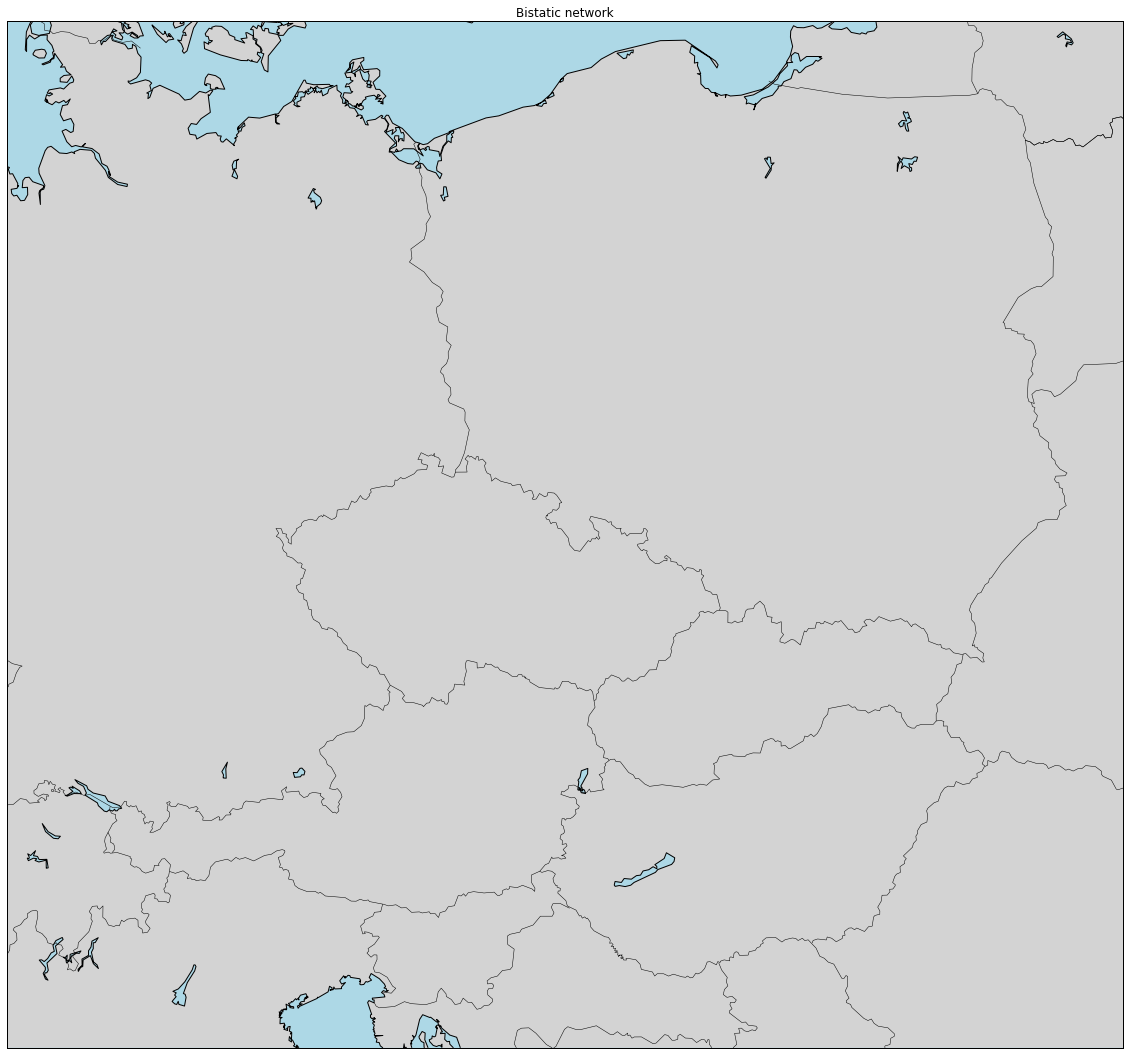

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap


land_color = 'lightgray'
water_color = 'lightblue'

fig, ax = subplots(figsize=(20,20))
map = Basemap(projection='merc', llcrnrlat=45, urcrnrlat=55,
            llcrnrlon=8, urcrnrlon=25, resolution='i',area_thresh = 50)

land_color = 'lightgray'
water_color = 'lightblue'

map.fillcontinents(color=land_color, lake_color=water_color)
map.drawcoastlines()
map.drawcountries()
#map.drawparallels(np.arange(-90.,120.,30.))
#map.drawmeridians(np.arange(0.,420.,60.))
map.drawmapboundary(fill_color=water_color)
ax.set_title('Bistatic network')

x, y = map(np.array(near_transmitters.longitude_deg), np.array(near_transmitters.latitude_deg))
map.plot(x, y, marker='o', markersize=6, markerfacecolor='red', linewidth=0)

x, y = map(rec_station_lon, rec_station_lat)
map.plot(x, y, marker='o', markersize=6, markerfacecolor='blue', linewidth=0)

for meteor in met_start_lon:
    map.drawgreatcircle(met_start_lon[meteor], met_start_lat[meteor], met_stop_lon[meteor], met_stop_lat[meteor],linewidth=2,color='green')

map.ax = ax

In [24]:
local_utils.dip_angle_lat(50, 14, 200, 49, 13, 6e3)

(-3.183648319700652, 32.622405351462056, 132.67572976804902)

Copute distance from meteor trail ends.

In [25]:
import pandas as pd

meteors_reflections = pd.DataFrame()
reflection = 0

for meteor in range(ZHR):    
    for transmitter in near_transmitters.index:
        # calculate distance between transmitter and meteor trail points. 
        meteors_reflections.loc[reflection, 'RX_start_ele'] , meteors_reflections.loc[reflection, 'RX_start_azi'], meteors_reflections.loc[reflection, 'RX_start_dist'] = local_utils.dip_angle_lat(rec_station_lat, rec_station_lon, rec_station_altitude, met_stop_lat[meteor], met_stop_lon[meteor], met_stop_altitude[meteor])
        meteors_reflections.loc[reflection, 'RX_stop_ele'] , meteors_reflections.loc[reflection, 'RX_stop_azi'], meteors_reflections.loc[reflection, 'RX_stop_dist'] = local_utils.dip_angle_lat(rec_station_lat, rec_station_lon, rec_station_altitude, met_start_lat[meteor], met_start_lon[meteor], met_start_altitude[meteor])
        meteors_reflections.loc[reflection, 'TX_start_ele'] , meteors_reflections.loc[reflection, 'TX_start_azi'], meteors_reflections.loc[reflection, 'TX_start_dist'] = local_utils.dip_angle_lat(near_transmitters.ix[transmitter].latitude_deg, near_transmitters.ix[transmitter].longitude_deg, near_transmitters.ix[transmitter].elevation_m, met_start_lat[meteor], met_start_lon[meteor], met_start_altitude[meteor], lcorr_for_refraction=False)
        meteors_reflections.loc[reflection, 'TX_stop_ele'], meteors_reflections.loc[reflection, 'TX_stop_azi'], meteors_reflections.loc[reflection, 'TX_stop_dist'] = local_utils.dip_angle_lat(near_transmitters.ix[transmitter].latitude_deg, near_transmitters.ix[transmitter].longitude_deg, near_transmitters.ix[transmitter].elevation_m, met_stop_lat[meteor], met_stop_lon[meteor], met_stop_altitude[meteor], lcorr_for_refraction=False)
        meteors_reflections.loc[reflection, 'TX_power'] = near_transmitters.ix[transmitter, 'power_w']
        reflection += 1

In [26]:
rcs_met = 100
RX_gain = 5
TX_gain = 10
for reflection in meteors_reflections.index:
    meteors_reflections.loc[reflection, 'start_dBm'] = sympy.N(PrdBm.subs([(Pt, meteors_reflections.loc[reflection, 'TX_power']), (Gt, TX_gain), (Ar, RX_gain), (RCS, rcs_met), (F, 1), (Rt, ( meteors_reflections.loc[reflection, 'TX_start_dist']*1000)), (Rr, (meteors_reflections.loc[reflection, 'RX_start_dist']*1000))], simultaneous=True))
    meteors_reflections.loc[reflection, 'stop_dBm'] = sympy.N(PrdBm.subs([(Pt, meteors_reflections.loc[reflection, 'TX_power']), (Gt, TX_gain), (Ar, RX_gain), (RCS, rcs_met), (F, 1), (Rt, ( meteors_reflections.loc[reflection, 'TX_stop_dist']*1000)), (Rr, (meteors_reflections.loc[reflection, 'RX_stop_dist']*1000))], simultaneous=True))

In [27]:
meteors_reflections

,RX_start_ele,RX_start_azi,RX_start_dist,RX_stop_ele,RX_stop_azi,RX_stop_dist,TX_start_ele,TX_start_azi,TX_start_dist,TX_stop_ele,TX_stop_azi,TX_stop_dist,TX_power,start_dBm,stop_dBm
0,-18.195912,117.319048,233.260312,-20.687689,-73.709470,343.257039,-15.230592,-78.064408,504.587934,-32.384474,165.242617,130.962464,100,-156.410051506616,-148.049823001805
1,-18.195912,117.319048,233.260312,-20.687689,-73.709470,343.257039,-18.037897,-58.199268,407.811213,-23.538522,86.497081,179.942643,200,-151.550197589785,-147.799268196122
2,-18.195912,117.319048,233.260312,-20.687689,-73.709470,343.257039,-20.756598,-105.300641,342.171858,-12.633546,142.306691,356.672551,200,-150.025900092307,-153.741980066165
3,-18.195912,117.319048,233.260312,-20.687689,-73.709470,343.257039,-15.780422,-81.758386,480.597974,-25.567364,160.265186,164.216244,200,-152.976653048126,-147.004908620963
4,-18.195912,117.319048,233.260312,-20.687689,-73.709470,343.257039,-20.119390,-55.275548,358.182740,-18.529464,89.374756,230.805099,200,-150.423107424435,-149.961494277391
5,-18.195912,117.319048,233.260312,-20.687689,-73.709470,343.257039,-17.518301,-72.974955,420.060356,-26.021080,124.297817,161.263040,50,-157.827848162244,-152.867883066568
6,-18.195912,117.319048,233.260312,-20.687689,-73.709470,343.257039,-15.508724,-57.613256,496.705809,-34.957292,57.226089,123.687217,200,-153.262999107386,-144.543082682427
7,-18.195912,117.319048,233.260312,-20.687689,-73.709470,343.257039,-20.305436,-108.898027,351.404185,-12.224916,144.602851,373.912790,200,-150.257152920495,-154.151992736455
8,-18.195912,117.319048,233.260312,-20.687689,-73.709470,343.257039,-22.519454,-63.884402,315.744410,-16.769084,103.884909,257.487582,50,-155.348327649090,-156.932311988623
9,-18.195912,117.319048,233.260312,-20.687689,-73.709470,343.257039,-29.751107,-98.315683,235.428769,-11.960338,123.900404,386.211004,200,-146.778204980943,-154.433079183210


In [28]:
signal_intensity = meteors_reflections['start_dBm']
signal_intensity = signal_intensity.append(meteors_reflections['stop_dBm'])

In [29]:
#plt.hist(signal_intensity, bins= 30)
#plt.title("Gaussian Histogram")
#plt.xlabel("Value")
#plt.ylabel("Frequency")
#plt.show()

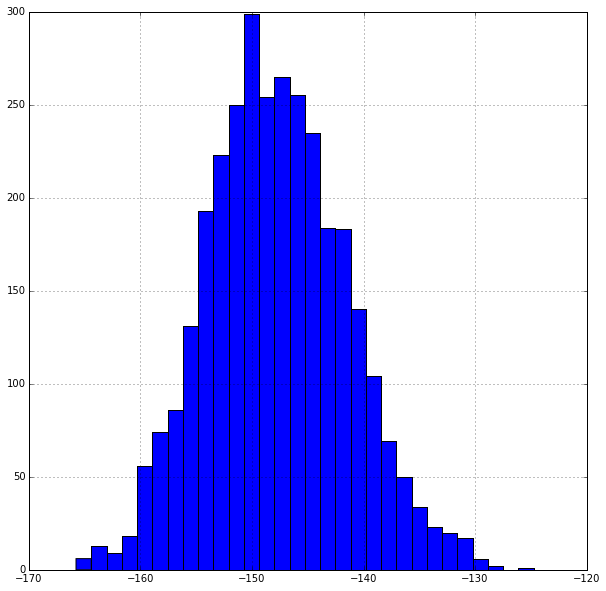

In [30]:
signal_intensity.hist(bins= 30, figsize= (10,10))

Doppler signal model
====================

* Compute Doppler shifted signal for multiple VOR beacons
* Display calculated results


In [31]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt 
import numpy as np
import scipy.constants
from Geocentric import Geocentric
geoC = Geocentric(6378137, 6356752.314)

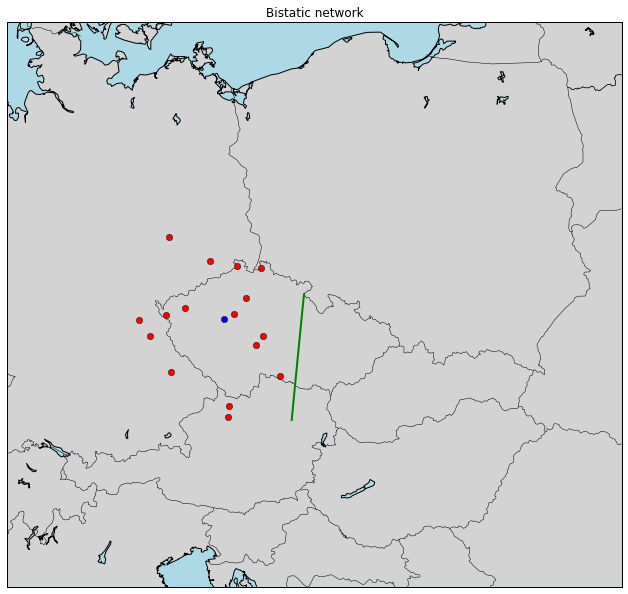

In [43]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap


land_color = 'lightgray'
water_color = 'lightblue'

fig, ax = subplots(figsize=(15,10))
map = Basemap(projection='merc', llcrnrlat=45, urcrnrlat=55,
            llcrnrlon=8, urcrnrlon=25, resolution='i',area_thresh = 50)

land_color = 'lightgray'
water_color = 'lightblue'

map.fillcontinents(color=land_color, lake_color=water_color)
map.drawcoastlines()
map.drawcountries()
#map.drawparallels(np.arange(-90.,120.,30.))
#map.drawmeridians(np.arange(0.,420.,60.))
map.drawmapboundary(fill_color=water_color)
ax.set_title('Bistatic network')

x, y = map(np.array(near_transmitters.longitude_deg), np.array(near_transmitters.latitude_deg))
map.plot(x, y, marker='o', markersize=6, markerfacecolor='red', linewidth=0)

x, y = map(rec_station_lon, rec_station_lat)
map.plot(x, y, marker='o', markersize=6, markerfacecolor='blue', linewidth=0)

meteor = 1

map.drawgreatcircle(met_start_lon[meteor], met_start_lat[meteor], met_stop_lon[meteor], met_stop_lat[meteor],linewidth=2,color='green')

map.ax = ax

Switch data to cartesian geocentric coordinates.

In [33]:
rec_station_point = np.array(geoC.GeographicToGeocentric(rec_station_lat, rec_station_lon, rec_station_altitude))

Then we convert meteor coordinates for one artificial meteor to X, Y, Z format.

In [34]:
met_start_point = np.array(geoC.GeographicToGeocentric(met_start_lat[0], met_start_lon[0], met_start_altitude[0]))
met_stop_point = np.array(geoC.GeographicToGeocentric(met_stop_lat[0], met_stop_lon[0], met_stop_altitude[0]))

met_vect = met_start_point - met_stop_point

Now we can compute set of points along the meteor trajectory.

In [35]:
t= 0.1
c = scipy.constants.c
f0 = near_transmitters.ix[near_transmitters.index[1]].frequency_khz * 1000
timesteps = np.arange(-10,10,t)
met_points = np.empty([timesteps.size, 3])

for i in range(timesteps.size):
    met_points[i] =  met_start_point + (met_vect/np.linalg.norm(met_vect) * (timesteps[i] * met_velocity[0]))

We can plot the points on meteor trajectory.

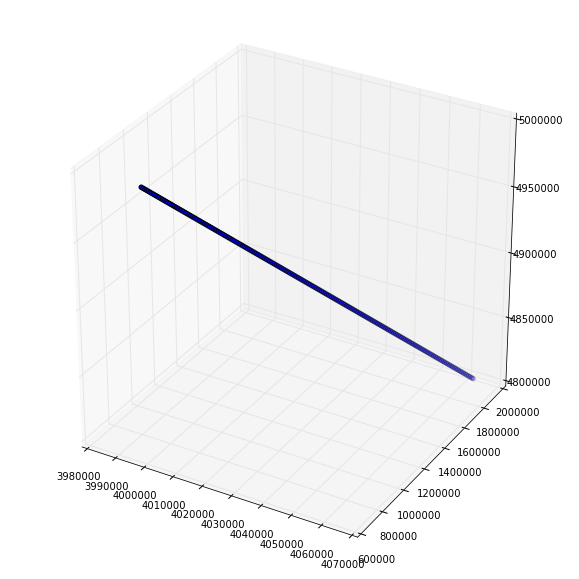

In [40]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter(met_points[:,0], met_points[:,1], met_points[:,2])

Finally we can compute dopplers for every point at the trajectory.

Using matplotlib backend: TkAgg


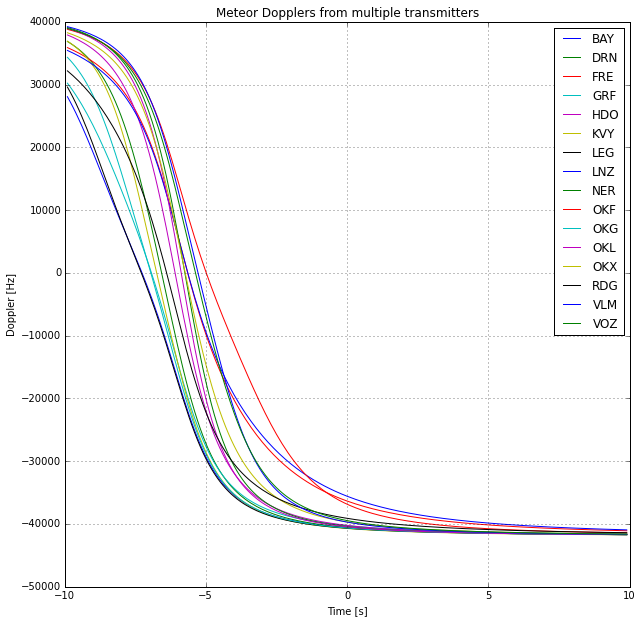

In [41]:
%matplotlib
fig, ax1 = plt.subplots(figsize=(10, 10))
ax1.set_title('Meteor Dopplers from multiple transmitters')
ax1.set_ylabel('Doppler [Hz]')
ax1.set_xlabel('Time [s]')
grid(True)

for transmitter in near_transmitters.index:
    trans_station_point = np.array(geoC.GeographicToGeocentric(near_transmitters.ix[transmitter].latitude_deg, near_transmitters.ix[transmitter].longitude_deg,near_transmitters.ix[transmitter].elevation_m))
    
    rec_to_met = np.empty([timesteps.size, 1])
    trans_to_met = np.empty([timesteps.size, 1])
    doppler = np.empty([timesteps.size, 2])
    
    previous_rec_to_met = np.linalg.norm(rec_station_point - met_points[0])
    previous_trans_to_met = np.linalg.norm(trans_station_point - met_points[0])
    
    for i in range(timesteps.size):
        rec_to_met[i] = np.linalg.norm(rec_station_point - met_points[i])
        trans_to_met[i] = np.linalg.norm(trans_station_point - met_points[i])
    
        met_trans_speed = previous_trans_to_met - trans_to_met[i]
        previous_trans_to_met = trans_to_met[i]
        speed = met_trans_speed/t    
        f1 = ((c + speed)/c * f0)
        
        met_rec_speed = previous_rec_to_met - rec_to_met[i]
        previous_rec_to_met = rec_to_met[i]
        speed = met_rec_speed/t
        f2 = (c/(c - speed) * f1)
        doppler[i] = np.array([timesteps[i], f2-f0])
        
    plt.plot(doppler[1:,0], doppler[1:,1], label=near_transmitters.ix[transmitter].ident)

plt.legend(loc=1)
